<a href="https://www.kaggle.com/code/nmd2104/uncovering-bias-through-latent-features?scriptVersionId=133875756" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Uncovering Bias through Learning Latent Features

Recent researches has highlighted the vulnerabilities of modern machine learning based systems to bias, especially towards segments of society that are under-represented in training data. For example, most of your training data is light-skinned people with under-represented dark-skinned people, or the training data might be "biased" towards some specific features such as hair color, light condition... which might leading to untrustworthy model

The development and deployment of fair and unbiased AI systems is crucial to prevent any unintended side effects and to ensure the long-term acceptance of these algorithms. In medical ecosystems, cancer classification problems have been researched long time ago with many powerful algorithms have been proposed. On the earliest day of Deep Learning, Convolutional NN is considered to be outstanding in image processing and classification problems. 

In this notebook, I will try to build a standard CNN for chest cancer images classification, and figure out whether or not our data set is bias. To accomplish the latter task, Variational Autoencoder (VAE) has been applied to find hidden latent features. Another approach is Semi-Supervised VAE which is motivated directly from [this paper](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf) allows us to figure the promising bias inside the class.

### Goal:
The goal in this notebook is not to build a sophisticated model with this problem, but uncover the potential bias hidden in the dataset through reconstruction loss. The model I built might be overfitting or underfitting, or even poor performance I will tackle those problems later but might give us some intuition about how condition in images affect the result of model.

# Import neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow as tf
plt.style.use("bmh")
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load Data and Visualization

In [2]:
seed_val = 42
np.random.seed(seed_val) # seed for numpy
tf.random.set_seed(seed_val) # seed for tensorflow

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print("Numbers of GPUs:", len(gpus))

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], enable=True)
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU Details:", details.get('device_name', 'Unknown GPU'))

Numbers of GPUs: 1
GPU Details: Tesla P100-PCIE-16GB


In [4]:
data_dir = "/kaggle/input/chest-ctscan-images/Data/train"

In [5]:
class_name = [cl for cl in os.listdir(data_dir)]
print(f"There are {len(class_name)} classes in the training set")

There are 4 classes in the training set


In [6]:
os.chdir("/kaggle/input/chest-ctscan-images/Data")

In [7]:
batch_size=64
img_size = (512, 512)

train_data = tf.keras.utils.image_dataset_from_directory("train", 
                                                       batch_size=batch_size, 
                                                       image_size=img_size, 
                                                       seed=0, 
                                                       label_mode='categorical', 
                                                       shuffle=True)

val_data = tf.keras.utils.image_dataset_from_directory("test", 
                                                     batch_size=batch_size,
                                                     image_size=img_size, 
                                                     seed=0, 
                                                     label_mode='categorical', 
                                                     shuffle=False)

test_data = tf.keras.utils.image_dataset_from_directory("valid", 
                                                      image_size=img_size,
                                                      seed=0,
                                                      label_mode='categorical',
                                                      shuffle=False)

Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.


In [8]:
train_data.class_names

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [9]:
for image_train, label_train in train_data:
    print(image_train.shape)
    print(label_train.shape)
    break

(64, 512, 512, 3)
(64, 4)


In [10]:
def pixel_range(data):
    image_batches, label_batches = next(iter(data))
    return np.min(image_batches[0]), np.max(image_batches[1])

In [11]:
min_pixel, max_pixel = pixel_range(train_data)
print(f"Min pixel: {min_pixel}\nMax pixel: {max_pixel}")

Min pixel: 0.0
Max pixel: 240.4154052734375


In [12]:
# standardize


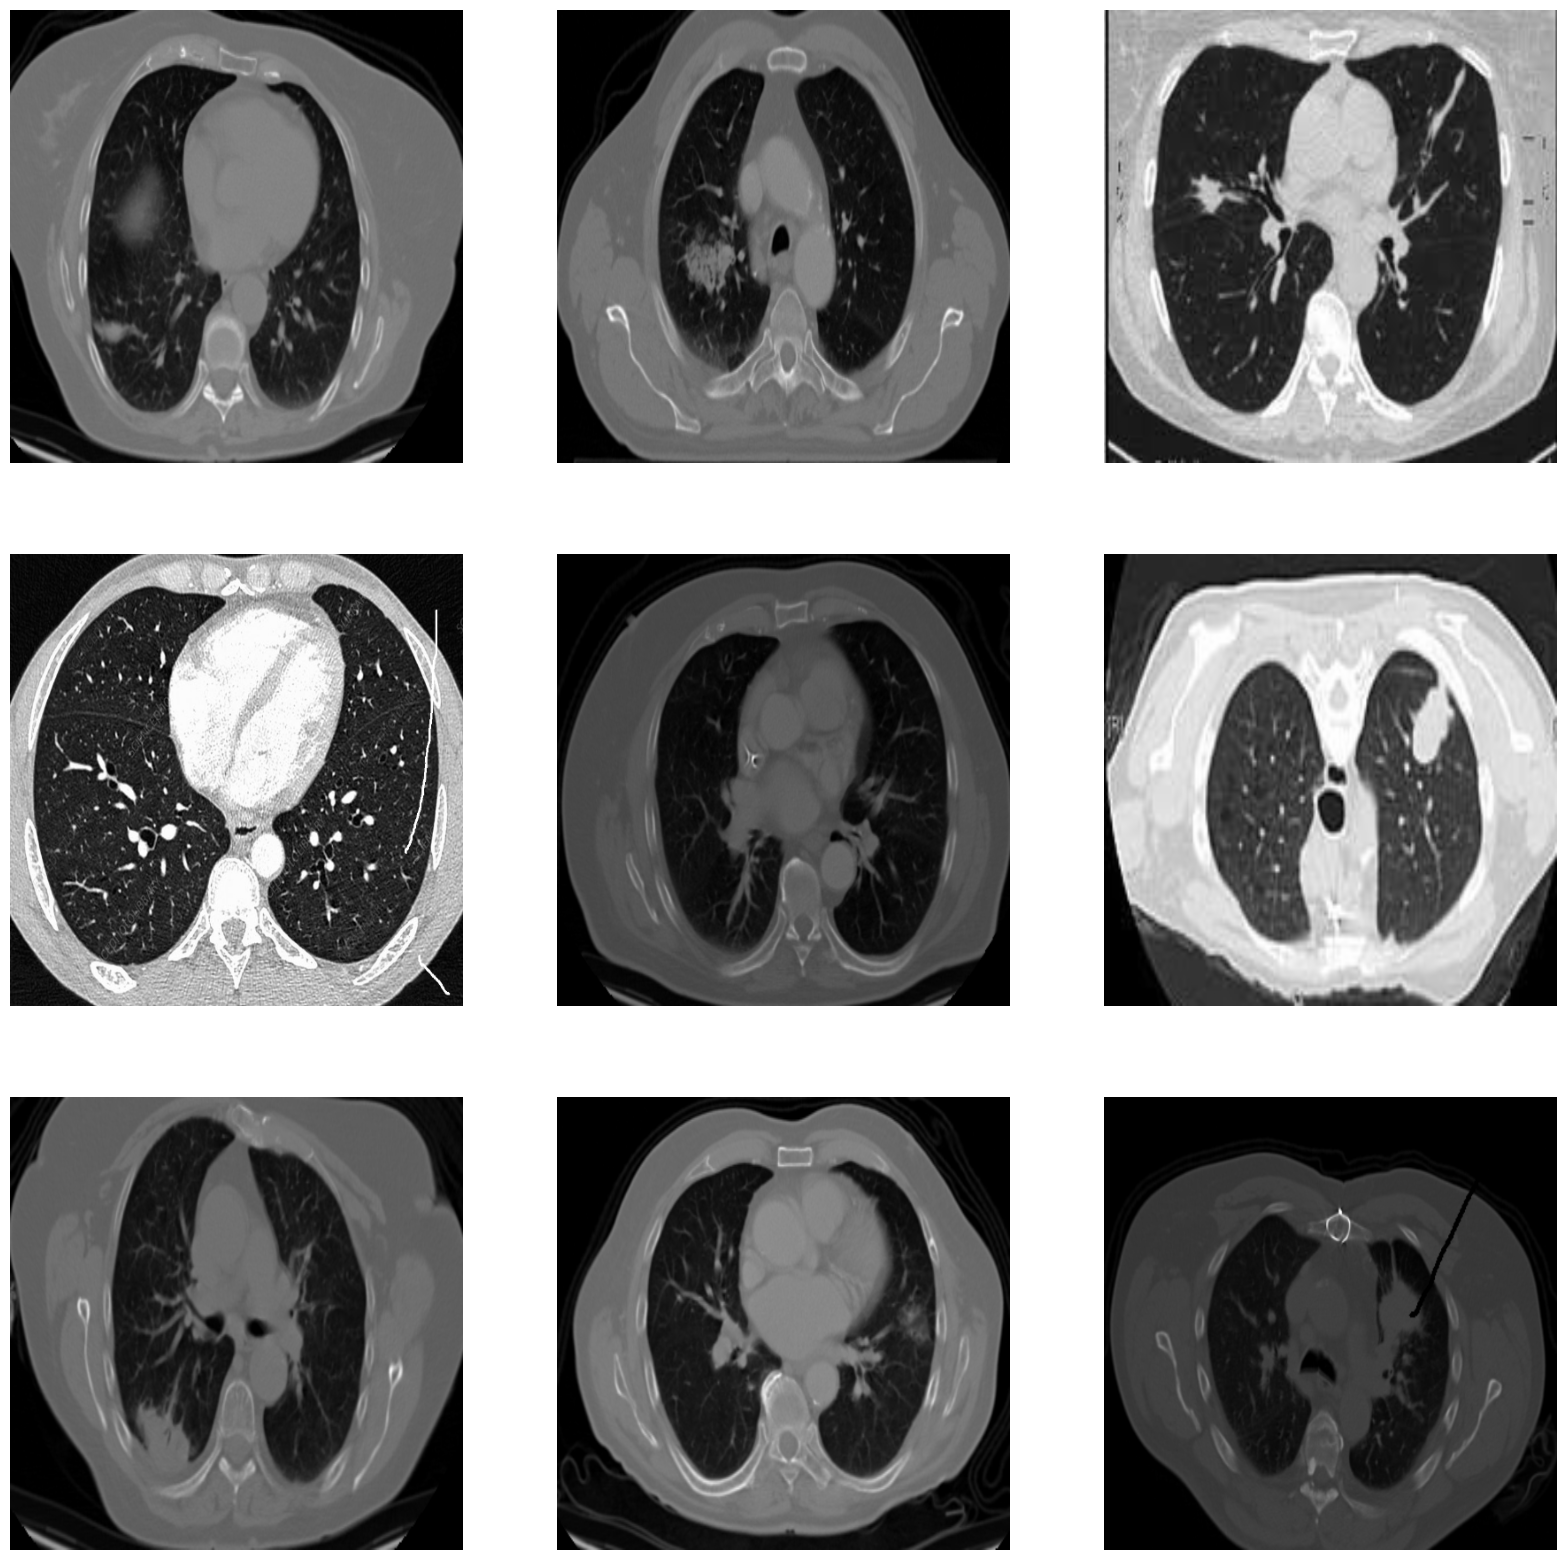

In [13]:
plt.figure(figsize = (20, 20))
for img, labels in train_data.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy()/255)
        plt.axis("off")
    
plt.show()

## Convert tf.BatchDatset to Numpy array

In [14]:
import tensorflow_datasets as tfds

In [15]:
x_train = np.empty(shape = 10, dtype = 'object')
y_train = np.empty(shape = 10, dtype = 'object')
for i, train_ in enumerate(tfds.as_numpy(train_data)):
    train_image, train_label = train_
    x_train[i] = train_image
    y_train[i] = train_label
    
print(f"Train images shape: {x_train.shape}")
print(f"Label images shape: {y_train.shape}")

Train images shape: (10,)
Label images shape: (10,)


In [16]:
x_train = x_train / 255

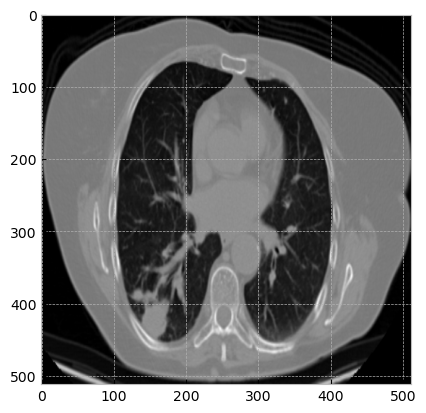

In [17]:
plt.imshow(x_train[0][0])

In [18]:
print(y_train[0][0])

[1. 0. 0. 0.]


# Standard Convolutional NN

In [19]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense, MaxPooling2D

In [20]:
# Hyperparameter
batch_size = 64
num_batch = 10
learning_rate = 5e-4
n_filters = 12

In [21]:
def make_standard_cnn(n_outputs = 4):
    model = tf.keras.Sequential([
        
        Conv2D(filters = 1*n_filters, kernel_size = 6, strides = 2, activation = 'relu', padding = 'same'),
        BatchNormalization(),
        
        Conv2D(filters = 2*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        BatchNormalization(),
        
        Conv2D(filters = 4*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        BatchNormalization(),
        
        Conv2D(filters = 6*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        BatchNormalization(),
        
        Conv2D(filters = 8*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        BatchNormalization(),

        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(n_outputs, activation = None) # we expect the logits not probabilities
        
    ])
    
    return model

In [22]:
standard_cnn = make_standard_cnn()

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
num_epochs = 8

@tf.function
def standard_train_loss_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = standard_cnn(x_batch)
        loss = tf.nn.softmax_cross_entropy_with_logits(y_batch, logits)
    
    grads = tape.gradient(loss, standard_cnn.trainable_variables)
    optimizer.apply_gradients(zip(grads, standard_cnn.trainable_variables))
    return loss

In [24]:
# Training loop
loss_history = []

for epoch in range(num_epochs):
    for b in range(num_batch):
        x_batch = x_train[b]
        y_batch = y_train[b]
        loss = standard_train_loss_step(x_batch, y_batch)
        loss_history.append(loss.numpy().mean())

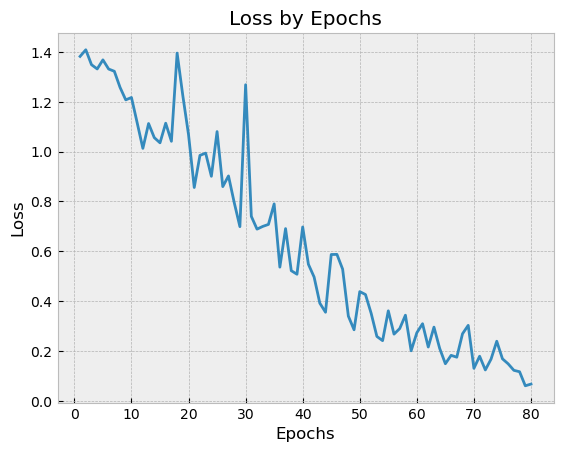

In [25]:
# Visualization loss by epochs
def visualize_loss_epochs(epochs, loss):
    plt.plot(epochs, loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss by Epochs")
    plt.show()
    
visualize_loss_epochs(np.arange(1, num_batch*num_epochs+1, 1), loss_history)

## Evaluate the standard CNN

I will find the average accuracy in a batch to evaluate the model

In [26]:
# Evaluate our CNN 
for b in range(num_batch):
    x_batch, y_batch = x_train[b], y_train[b]
    sm_y_pred = tf.nn.softmax(standard_cnn.predict(x_batch))
    std_y_pred = tf.cast(tf.equal(sm_y_pred, tf.reduce_max(sm_y_pred, axis = 1, keepdims = True)), tf.float32)
    std_acc = tf.reduce_mean(tf.cast(tf.equal(y_batch, std_y_pred), tf.float32))

    print(f"The average accuracy on batch {b+1} is {std_acc}")

2/2 [==============================] - 1s 34ms/step
The average accuracy on batch 1 is 0.9609375
2/2 [==============================] - 0s 34ms/step
The average accuracy on batch 2 is 0.9765625
2/2 [==============================] - 0s 34ms/step
The average accuracy on batch 3 is 0.9765625
2/2 [==============================] - 0s 34ms/step
The average accuracy on batch 4 is 0.9765625
2/2 [==============================] - 0s 34ms/step
The average accuracy on batch 5 is 0.9765625
2/2 [==============================] - 0s 64ms/step
The average accuracy on batch 6 is 0.9765625
2/2 [==============================] - 0s 34ms/step
The average accuracy on batch 7 is 0.96875
2/2 [==============================] - 0s 34ms/step
The average accuracy on batch 8 is 0.9765625
2/2 [==============================] - 0s 72ms/step
The average accuracy on batch 9 is 1.0
2/2 [==============================] - 0s 81ms/step
The average accuracy on batch 10 is 1.0


# Variational Autoencoders

In practice, how can we train latent variables - which is based on sampling from latent distribution. Since variational autoencoder introduces some randomness, we can not back propagate through latent space directly. 
- Solving this problem by reparameterization trick which turn $z = \mu + \sigma*\epsilon$ where $\epsilon$ is a random variable following our defined distribution (in this case normal distribution). Then the latent variables $z$ are constructed from 2 parameters $\mu$ and $\sigma$ which can be propagated

Another problem is the training loss function for CNN to optimize. Up to now we use only cross entropy loss between predicted labels and true ones. This type of loss is known as __Classification loss__ for most of supervised problems. Beside that, VAE also introduces 2 more types of error
- __Latent loss__: The distance between the true distribution of latent variables and the distribution we are expecting. In practice, some special distributions such as Gaussian, Exponential, etc. are usually imposed on the latent variables to ensure about the latter reconstruction ability. Usually be measured from KL divergence
- __Reconstruction loss__: The main motivation with VAE is to reconstruct a new data point which is similar to the original one. By optimize this process, the VAE will have ability to capture some hidden layers (and then can reconstruct data points well). Simply measured by distance between $x$ and $\hat{x}$

*__Loss function for original VAE__*

$$\mathcal{L} = c.L_{KL} + L(x, \hat{x})$$

With normality assumption on $z$, the latent loss is defined as

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

In [27]:
# VAE loss
def get_vae_loss(x, x_recon, mu, logsigma, c = 0.0005):
    latent_loss = tf.reduce_sum(tf.math.exp(logsigma) + tf.math.square(mu) - 1 - logsigma)*0.5
    reconstruct_loss = tf.reduce_mean(tf.math.abs(x - x_recon), axis = [1,2,3])
    vae_loss = latent_loss*c + reconstruct_loss
    return vae_loss

Imagine that we feed the model with batches containing `batch_size` examples, we have to get `batch_size` values of latent variables which is in `latent_dims`. In higher dimensions, the reparameterization $z = \mu + \sigma* \epsilon$ will become:

$$z = \mu + \Sigma^{1/2} * \epsilon \quad \text{or} \quad z = \mu + e^{0.5\log \Sigma} * \epsilon$$
where $\epsilon \sim N(0, I)$

In [28]:
# Sampling z
def sampling(z_mean, z_logsigma):
    batch_size, latent_dims = z_mean.shape
    epsilon = tf.random.normal(shape = (batch_size, latent_dims))
    
    z = z_mean + tf.math.exp(0.5*z_logsigma)*epsilon
    return z

In [29]:
def make_decoded_network(n_filters = 12):
    Conv2DTranspose = tf.keras.layers.Conv2DTranspose
    Reshape = tf.keras.layers.Reshape
    
    model = tf.keras.Sequential([
        Dense(16*16*8*n_filters, activation = 'relu'),  # 16x16 feature maps
        Reshape(target_shape = (16, 16, 8*n_filters)),
        
        Conv2DTranspose(filters = 6*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        Conv2DTranspose(filters = 4*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        Conv2DTranspose(filters = 2*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        Conv2DTranspose(filters = 1*n_filters, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same'),
        Conv2DTranspose(filters = 3, kernel_size = 6, strides = 2, padding = 'same')
    ])
    return model

In [30]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims

        num_encoder_dims = 2*self.latent_dims # latent dim need both mu and sigma
        self.encoder = make_standard_cnn(num_encoder_dims)
        self.decoder = make_decoded_network()
    
    def encode(self, x): # encode input tensor
        encoder_output = self.encoder(x)
        z_mean = encoder_output[:, :self.latent_dims]
        z_logsigma = encoder_output[:, self.latent_dims:]
        
        return z_mean, z_logsigma
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction
    
    def call(self, x):
        z_mean, z_logsigma = self.encode(x)
        z = sampling(z_mean, z_logsigma)
        x_recon = self.decode(z)
        
        return x, x_recon, z_mean, z_logsigma
    
    def predict(self, x):
        x, x_recon, z_mean, z_logsigma = self.call(x)
        return x_recon

In [31]:
# Hyperparameter
batch_size = 64
learning_rate = 5e-4
num_epochs = 10
latent_dims = 32
num_batchs = 10

vae = VAE(latent_dims)
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# Training loop

def vae_train_loss_step(x):
    with tf.GradientTape() as tape:
        x, x_recon, z_mean, z_logsigma = vae.call(x)
        loss = get_vae_loss(x, x_recon, z_mean, z_logsigma)
    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    
    return loss


loss_history = []
for e in range(num_epochs):
    for b in range(num_batchs):
        x_batch = x_train[b]
        loss = vae_train_loss_step(x_batch)
        loss_history.append(loss.numpy().mean())

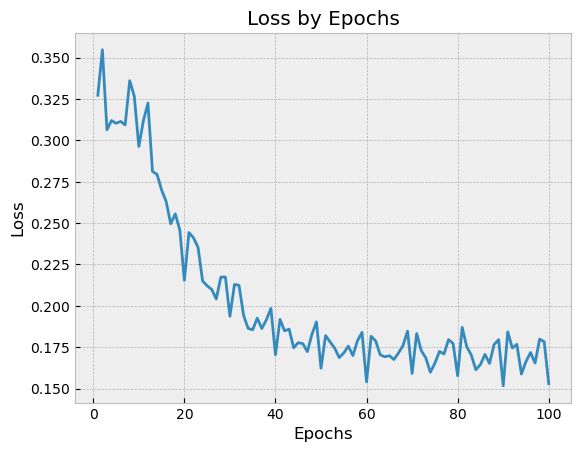

In [32]:
visualize_loss_epochs(np.arange(1, num_epochs*num_batchs+1, 1), loss_history)

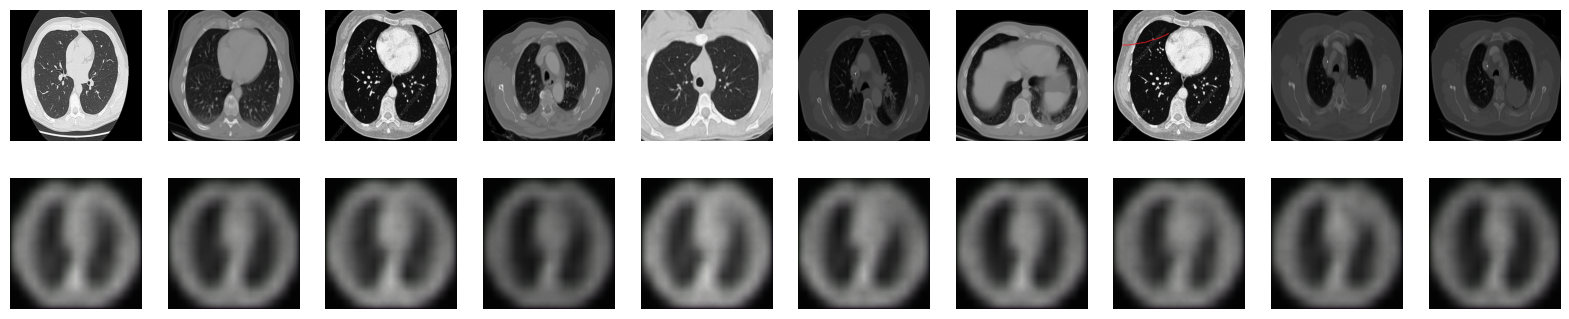

In [33]:
# Let's try to reconstruct some images
plt.figure(figsize = (20, 4))
batch = 2
x = x_train[batch]
x_recon = vae.predict(x)

for i in range(0,10,1):
    ax = plt.subplot(2,10,i+1)
    plt.imshow(x[i])
    plt.axis('off')
    ax = plt.subplot(2,10,i+11)
    plt.imshow(x_recon[i])
    plt.axis("off")
    
plt.show()

In [34]:
# Sort by reconstruction loss

recon_loss = np.empty(shape = (num_batchs, batch_size)) # to differetiate with real mean value
for b in range(num_batchs):
    x_original = x_train[b]
    x_recons = vae.predict(x_original)
    for i, x in enumerate(x_original):
        x_recon = x_recons[i]
        reconstruct_loss = tf.reduce_mean(tf.math.abs(x - x_recon))
        recon_loss[b][i] = reconstruct_loss

In [35]:
max_recon = np.argmax(recon_loss, axis = 1)
min_recon = np.argmin(recon_loss, axis = 1)

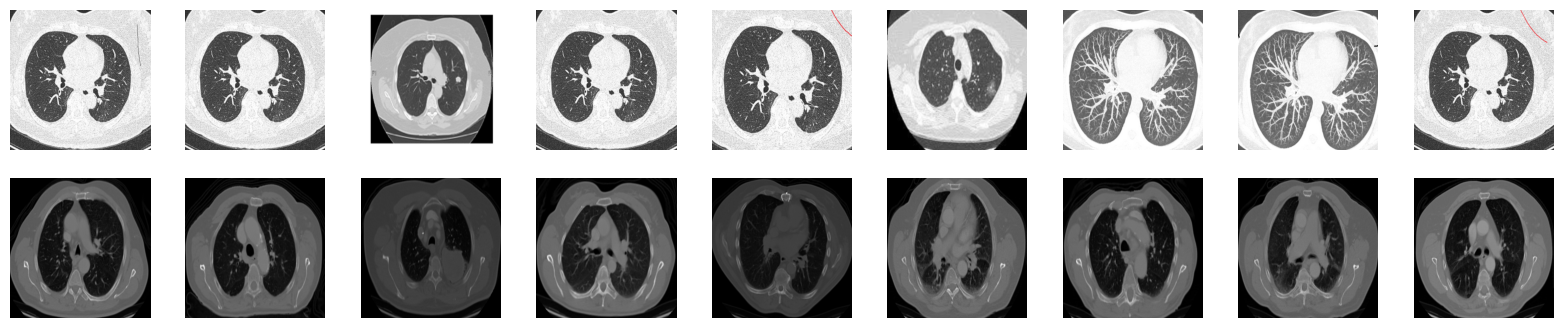

In [36]:
plt.figure(figsize = (20, 4))

for b in range(num_batchs-1):
    max_id, min_id = max_recon[b], min_recon[b]
    ax = plt.subplot(2,9, b+1)
    plt.imshow(x_train[b][max_id])
    plt.axis('off')
    ax = plt.subplot(2,9,b+10)
    plt.imshow(x_train[b][min_id])
    plt.axis("off")
    
plt.show()

Interestingly, the variational autoencoders indicate that for chest images which are light-colored, with dark background which separate chest components and the environment components. In contrast, the below row of images have higher reconstruction loss, which can be seen as being totally different from the above images. As using standard convolutional neural networks built before (99% accuracy) as encoder and then decode its through similar convolutional layers, it can be observed that the model is __bias__ towards some lighter and more focusing image instances.

Since the VAE has not classified the images yet, this phenomenon can also be caused by __aleatoric uncertainty__ in the model.

# Semi-Supervised Variational Autoencoder

We will develop a semi supervised VAE with supervised components. Specifically, the output for encoders should includes both latent variables (which is for unsupervised manner) and the predicted label for each input. 
A general schematic of SS_VAE architecture is shown below

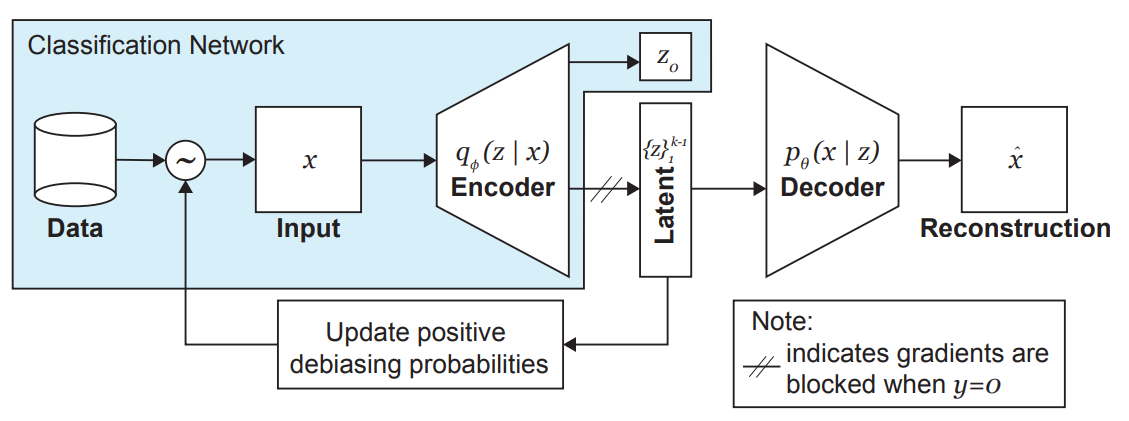

Keep in mind that we only want to learn the representation of non-normal images, i.e we care about images with sign of suffering from cancer. 
For cancer images, our loss will have two loss components:
- __VAE loss__: the loss to optimize reconstruction
- __Classification loss__: the loss for supervised task

For normal images, the loss is only classification loss. Thus, the general loss function for both cases should be

$$L_{SS-VAE} = L(\hat{y}, y) + I[y \neq 3].L_{VAE}$$

In [37]:
def get_ss_vae_loss(x, x_recon, y, y_logits, mu, logsigma):
    indicator = tf.cast(tf.equal(tf.reduce_sum(tf.cast(tf.equal(y, tf.constant([0,0,1,0])), tf.float32),axis = 1), 4), tf.float32)
    vae_loss = get_vae_loss(x, x_recon, mu, logsigma).numpy()
    classification_loss = tf.nn.softmax_cross_entropy_with_logits(y, y_logits)
    
    loss = classification_loss + (1-indicator) * vae_loss
    return loss, vae_loss, classification_loss

In [38]:
class SS_VAE(tf.keras.Model):
    def __init__(self, latent_dims):
        super(SS_VAE, self).__init__()
        self.latent_dims = latent_dims
        num_encoder_dims = 2*self.latent_dims + 4
    
        self.encoder = make_standard_cnn(num_encoder_dims)
        self.decoder = make_decoded_network()
        
    def encode(self, x):
        encoder_output = self.encoder(x)
        y_logits = encoder_output[:, :4]
        z_mean = encoder_output[:, 4:self.latent_dims+4]
        z_logsigma = encoder_output[:, self.latent_dims+4:]
        return z_mean, z_logsigma, y_logits
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction
    
    def call(self, x):
        z_mean, z_logsigma, y_logits = self.encode(x)
        z = sampling(z_mean, z_logsigma)
        x_recon = self.decode(z)
        return x, x_recon, z_mean, z_logsigma, y_logits
    
    def predict(self, x):
        x, x_recon, z_mean, z_logsigma, y_logits = self.call(x)
        return x_recon, y_logits

In [39]:
ss_vae = SS_VAE(latent_dims)

In [40]:
# train ss vae loss step
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
def ss_vae_loss_step(x, y):
    
    with tf.GradientTape() as tape:
        x, x_recon, z_mean, z_logsigma, y_logits = ss_vae.call(x)
        loss, vae_loss, classification_loss = get_ss_vae_loss(x, x_recon, y, y_logits, z_mean, z_logsigma)
        
    grads = tape.gradient(loss, ss_vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
    return loss

# Training loop

loss_history = []
for e in range(num_epochs):
    for b in range(num_batchs):
        x, y = x_train[b], y_train[b]
        loss = ss_vae_loss_step(x, y).numpy().mean()
        loss_history.append(loss)
            

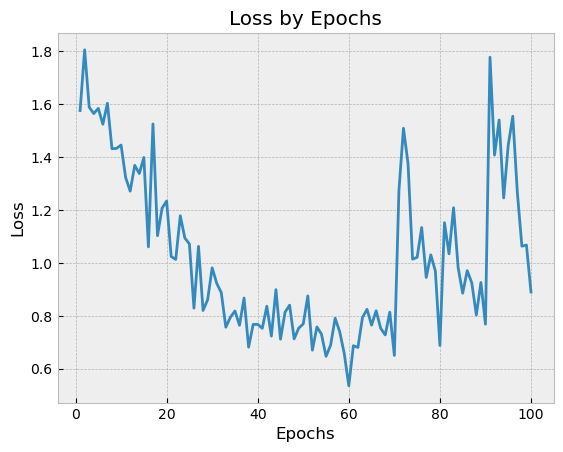

In [41]:
visualize_loss_epochs(np.arange(1, num_epochs*num_batchs +1, 1), loss_history)

In [42]:
# Evaluate our SS-VAE
ss_vae_recon_loss = np.empty(shape = (num_batchs-1, batch_size))

for b in range(num_batchs-1):
    x_batch, y_batch = x_train[b], y_train[b]
    x_recon, y_logits = ss_vae.predict(x_batch)
    
    reconstruct_loss = tf.reduce_mean(tf.math.abs(x_batch - x_recon), axis = [1,2,3])
    ss_vae_recon_loss[b, :] = reconstruct_loss
    
    sm_y_pred = tf.nn.softmax(y_logits)
    y_pred = tf.cast(tf.equal(sm_y_pred, tf.reduce_max(sm_y_pred, axis = 1, keepdims = True)), tf.float32)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_batch, y_pred), tf.float32))

    print(f"The average accuracy on batch {b+1} is {acc}")

The average accuracy on batch 1 is 0.96875
The average accuracy on batch 2 is 0.984375
The average accuracy on batch 3 is 0.9453125
The average accuracy on batch 4 is 0.953125
The average accuracy on batch 5 is 0.9453125
The average accuracy on batch 6 is 0.9453125
The average accuracy on batch 7 is 0.953125
The average accuracy on batch 8 is 0.96875
The average accuracy on batch 9 is 0.96875


# Bias in each classes 

In [43]:
def get_categorical_class(onehot_label):
    return np.argmax(onehot_label)

def bias_in_class(num_batchs, num_classes, batch_size):
    recon_loss_by_class = {c+1: [] for c in range(num_classes)}
    class_id_track = {c+1:[] for c in range(num_classes)}
    for c in range(num_classes):
        for b in range(num_batchs-1):
            for i in range(batch_size):
                label = get_categorical_class(y_train[b][i])
                if label == c: 
                    recon_c = ss_vae_recon_loss[b][i]
                    recon_loss_by_class[c+1].append(recon_c)
                    class_id_track[c+1].append((b, i))
                else: continue
    for c in range(num_classes):
        recon_c = recon_loss_by_class[c+1]
        recon_loss_by_class[c+1] = np.array(recon_c)
    return recon_loss_by_class, class_id_track

In [44]:
num_classes = 4
recon_loss_by_class, class_id_track = bias_in_class(num_batchs, num_classes, batch_size)

In [45]:
def visualize_bias_by_class(recon_loss_by_class: dict, class_id_track, num_classes):
    plt.figure(figsize = (20, 8))
    
    for c in range(num_classes):
        recon_losses = recon_loss_by_class[c+1]
        top5max = np.argsort(-recon_losses)[:5]
        top5min = np.argsort(recon_losses)[:5]
        minmax_id = np.hstack((top5min, top5max))
        batch_id = [class_id_track[c+1][j] for j in minmax_id]
        for i in range(10):
            ax = plt.subplot(4, 10, i+1 + c*10)
            plt.imshow(x_train[batch_id[i][0]][batch_id[i][1]])
            ax.set_title(c+1)
            plt.axis("off")

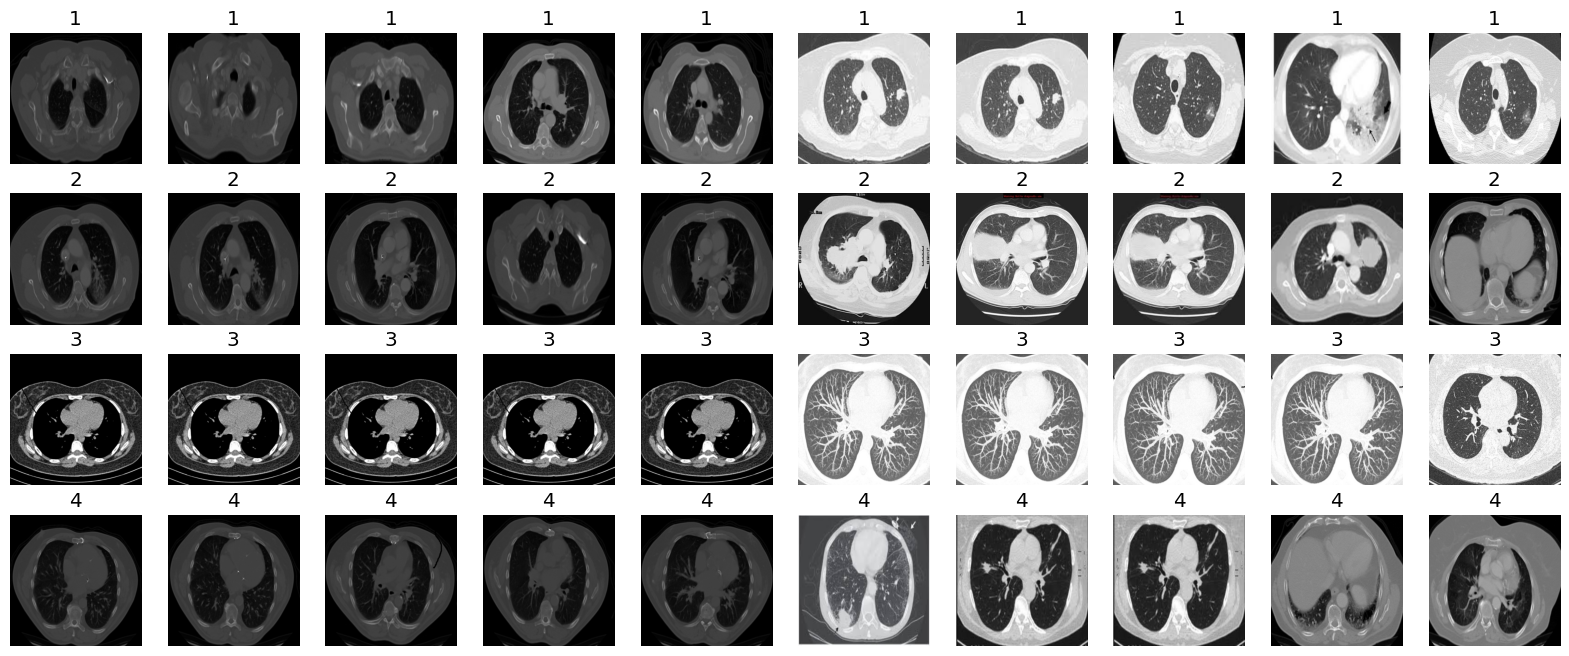

In [46]:
visualize_bias_by_class(recon_loss_by_class, class_id_track, num_classes)

One again, our assumption before about the causes of bias in the dataset shown here. At every classes, there are some slight difference between reconstruction loss between instances coming from the same class. On the left hand side are the ones which have the highest reconstruction loss and the remaining images are the ones with lowes reconstruction loss which are obviously ligher and more focusing on the main object (chest scan). This phenomenon appears at every single class